If you already have RStudio, this would be a good point to try and install Seurat so you can follow this interactive session. If not, I will basically take you through a full single-cell RNA-seq analysis tutorial, and I can send you this as a pdf so you can explore it yourself and even try it if you can get access to the Seurat package and/or Rstudio or anything else you like to code in R.

### Introduction

In this tutorial, we will analyze a dataset of Peripheral Blood Mononuclear Cells (PBMC) as generated by 10X genomics, a popular sequencing platform. They have a whole host of datasets you can explore in multiple tissues (brain and blood are popular) and organisms (mouse and human), exploring multiple modalities (ATAC-seq, Immune tagging, scDNA-seq). You can explore these [here](https://www.10xgenomics.com/resources/datasets).


Your typical 10X sequencing run will give you a set of FastQ files that will have to be mapped to a reference genome (Rahel Feleke). Once this is complete, you should have an output similar to this;



In [1]:
list.files("../../data/filtered_gene_bc_matrices/hg19/")

[1] "barcodes.tsv" "genes.tsv"    "matrix.mtx"



"Seurat" is one of the most commonly used packages for single-cell analysis in R and provides a host of functionalities for single-cell RNA-seq, ATAC-seq and CITE-seq (protein) analysis, from initial processing down to visualization and more complicated downstream analyses. The full set of functionalities can be explored on their [website](https://satijalab.org/seurat/index.html) and their pulications;

- Hao, et al., bioRxiv 2022 [Seurat v5]
- Hao*, Hao*, et al., Cell 2021 [Seurat v4]
- Stuart*, Butler*, et al., Cell 2019 [Seurat v3]
- Butler, et al., Nat Biotechnol 2018 [Seurat v2]
- Satija*, Farrell*, et al., Nat Biotechnol 2015 [Seurat v1]





### STEP 1: Reading in the data and basic QC statics

We will now read in the data outputs and process them within R. First, we load two libraries in R. 

In [84]:
options(repr.plot.width=10,repr.plot.height=7)

In [3]:
library(Seurat)
library(dplyr)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




The Read10X is specific from the Seurat package and takes as input a folder with 10X outputs. We first read the data in, and take a quick look at what the raw count matrix looks like;

In [4]:
pbmc.data <- Read10X(data.dir = "../../data/filtered_gene_bc_matrices/hg19/")
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]
dim(pbmc.data)

  [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

[1] 32738  2700

A sparse matrix is a method of compressing large matrices. As you can see from the `dim()` command, we have count values for 32,738 genes in 2700 cells. Non-counts (a value of 0) have been replaced with dots to save space. Finally, we create a Seurat object from this raw count matrix. This structures the data into a user friendly format.

In the below command, the `CreateSeuratObject()` function is used with two extra parameters; `min.cells=3` and `min.features=200`. This is the first step in cleaning the data - we only include genes that are expressed (non-zero counts) in at least 3 cells, and cells which have non-zero expression in at least 200 genes. 


In [5]:
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

As you can see, we have retained the full set of 2700 cells, but now only have 13,714 genes left.

To get an overview of how the counts are distributed per cell, we can generate ViolinPlots using the `VlnPlot()` function. We can then visualize the distribution of counts vs RNA features (genes) in a scatterplot using  the `FeatureScatter()` function.

In [6]:
plot1<-VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

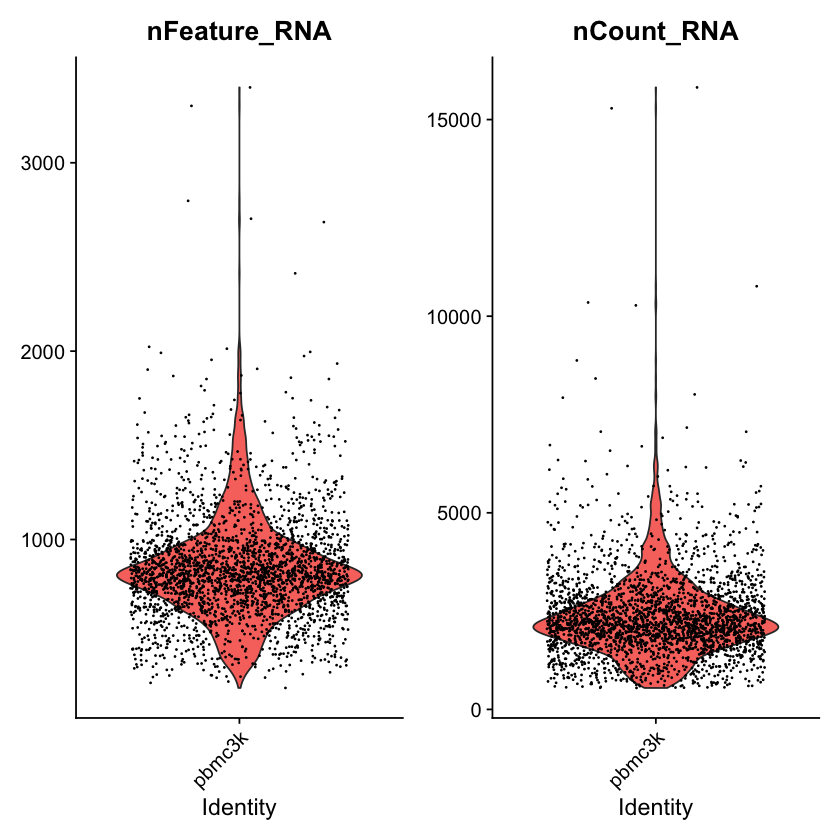

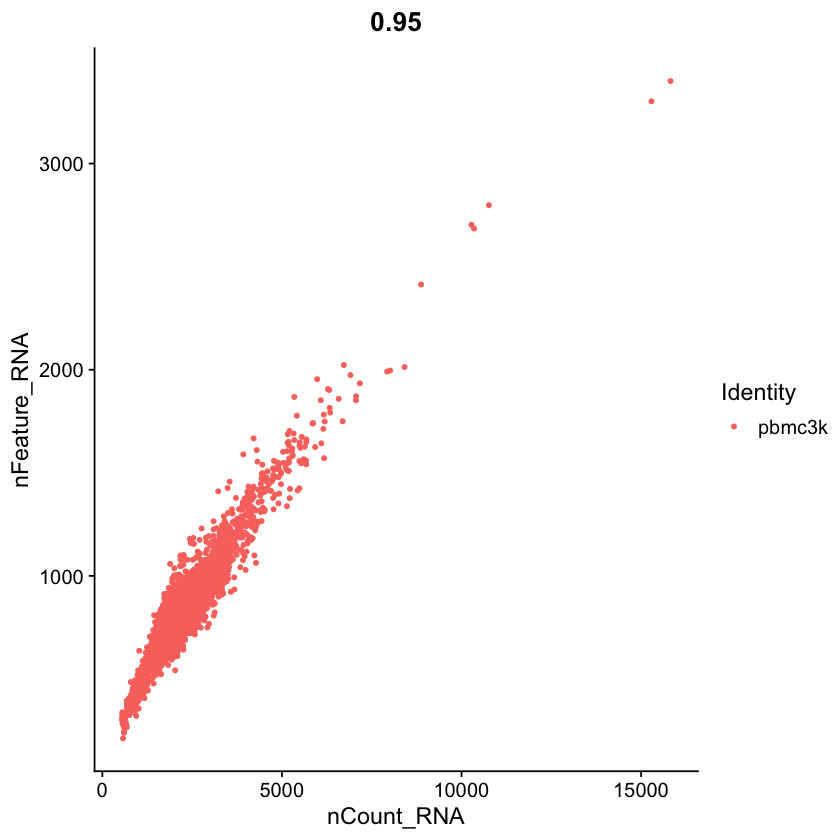

In [7]:
plot1
plot2


A common filtering criteria is the percentage of Mitochondrial reads. First, we tag the mitochondrial genes by finding the "MT" pattern in the gene names. Then, we use the Seurat function `PercentageFeatureSet()` to conveniently calculate the proportion of reads for each cell which are assigned to any of the MT genes.pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-") and visualize it again with a ViolinPlot.

>Generally speaking, a high percentage of mitochondrial genes indicate cell stress and potentially low quality cells. Bear in mind that this is highly specific to the analysis; certain tissue types may have naturally high mitochondrial content, so there isn't a "one-size-fits-all" mitochondrial threshold for single-cell QC. Generally, 5-10% is acceptable but again can depend on your analysis. Here, we will exclude cells with more than 5% MT content.

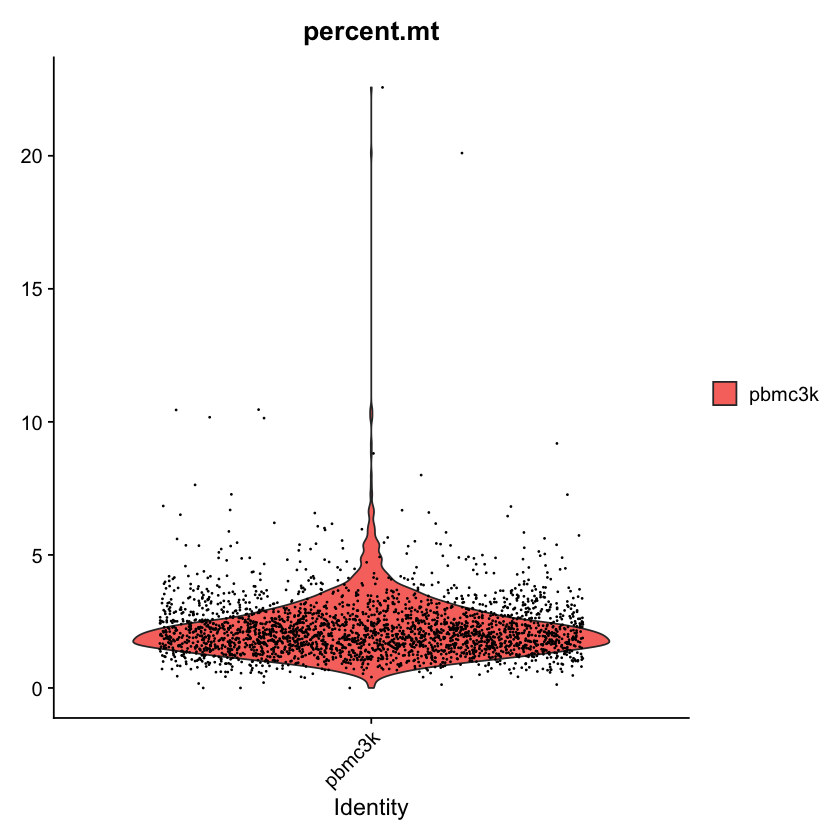

In [8]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
# Visualize QC metrics as a violin plot
VlnPlot(pbmc,features="percent.mt", ncol = 1)

We will further QC the object by selecting specific thresholds. You can look at the difference between these plots and the previous ones. Pay attention to the scales!
> Tip: Try playing around with different thresholds and see how the outputs differ!


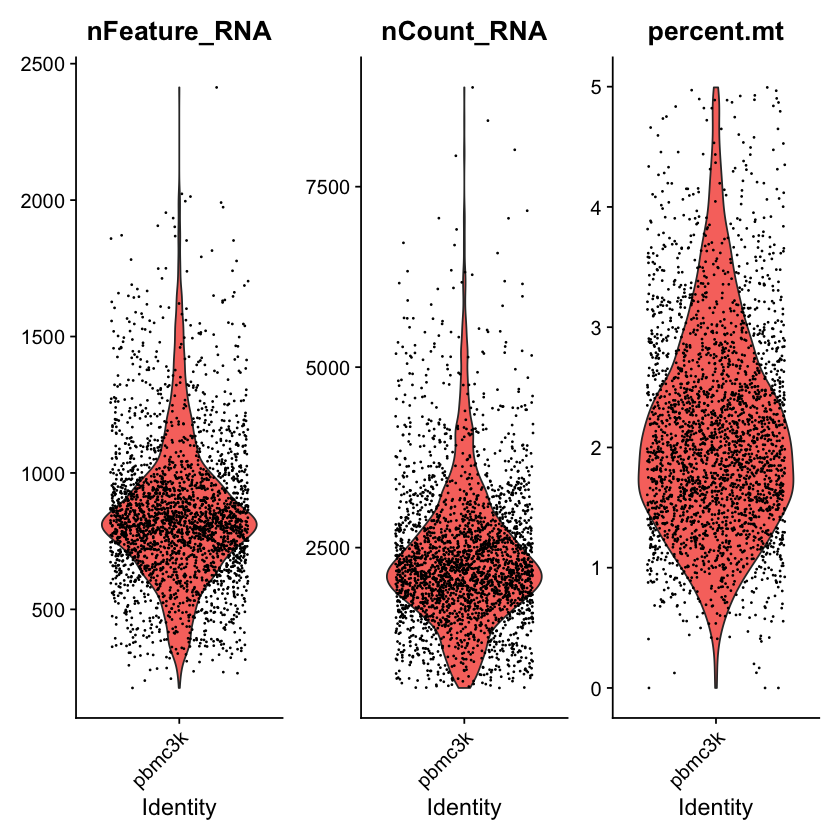

In [9]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA","percent.mt"), ncol = 3)

### STEP 2: Normalizing and scaling the data

Normalizing is an important step in processing expression matrices to ensure the reads follow a normal distribution. In doing so, we can apply statistical tools that work on the assumption of a normal distribution. Here, we perform a log-normalisation, which normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the results. `Seurat` will store this in a new slot on the same object.

In [10]:

pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
pbmc <- NormalizeData(pbmc)

Single-cell data is notorious for being zero-inflated, as can be seen in the below histogram. As a result, there is a continuous effort in the development of tools that accurately model single-cell count distribution. The above normalization is one of many and could be argued to be the simplest (check out SCTransform for example, or Zero Inflated negative Binomial models (ZINB)).

We can see this below in the first histogram; but if we play with the axis limits, we can see that we have obtained a mostly normal distribution.

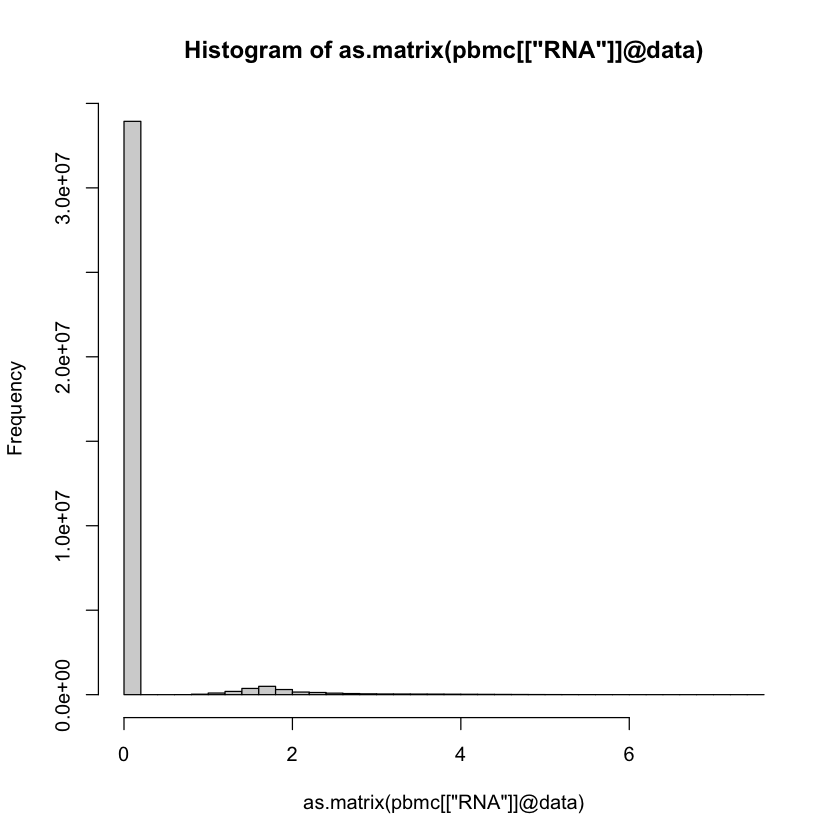

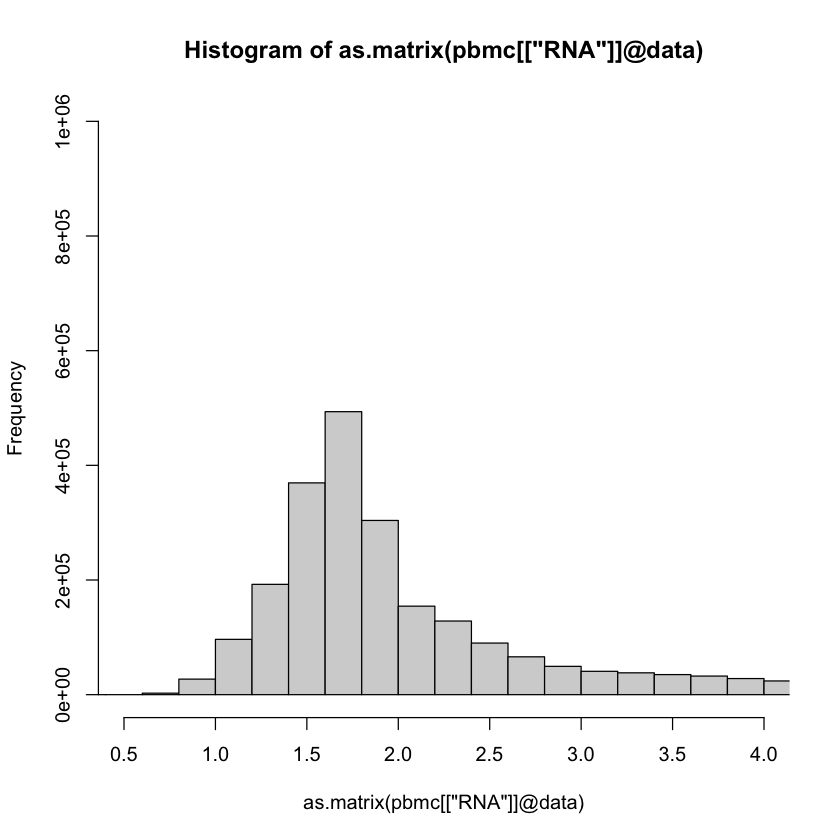

In [11]:
hist(as.matrix(pbmc[["RNA"]]@data))
hist(as.matrix(pbmc[["RNA"]]@data),xlim = c(0.5,4),ylim=c(0,1e6))

These are the counts before normalization, as noted by the `@counts` call.

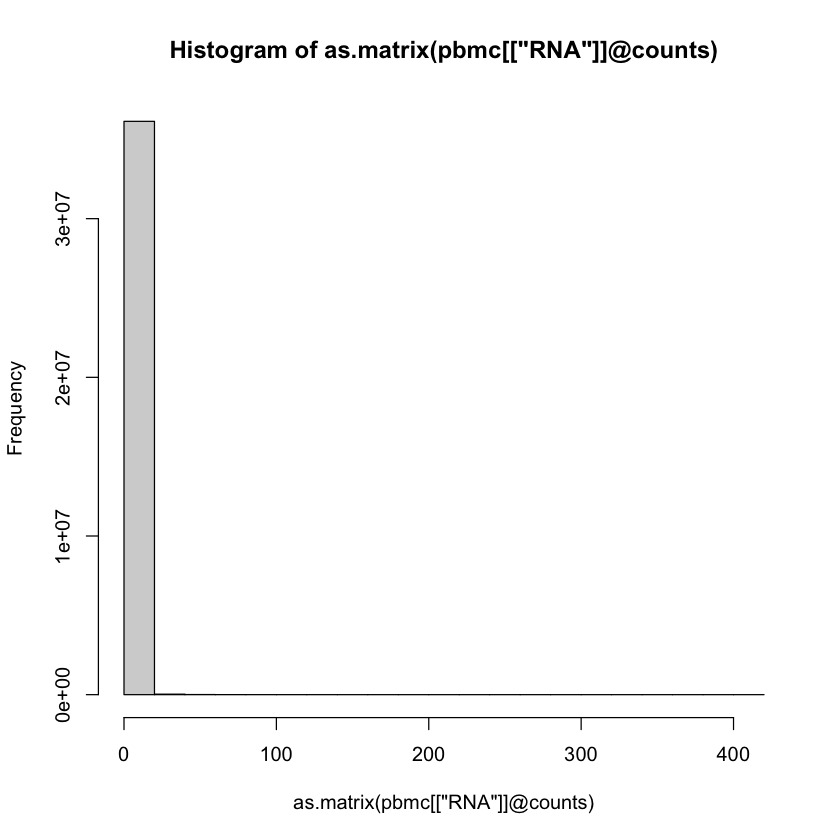

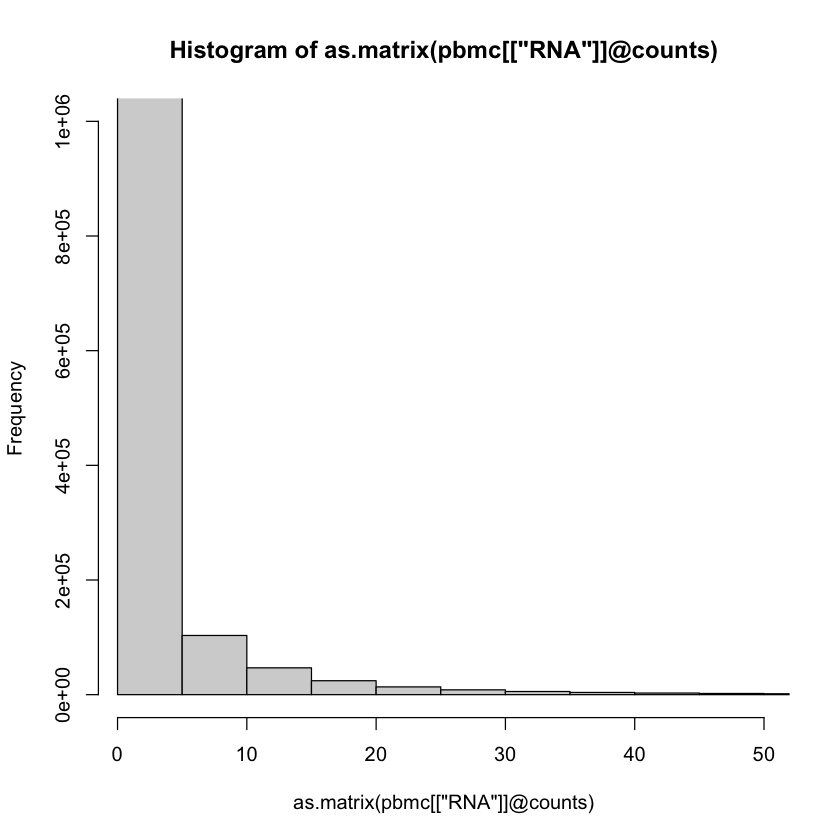

In [18]:
hist(as.matrix(pbmc[["RNA"]]@counts))
hist(as.matrix(pbmc[["RNA"]]@counts),xlim = c(0.5,50),ylim=c(0,1e6),breaks=100)

The next step is to find the most variable features, i.e the genes that drive the variation within the single-cell dataset. We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). We do this doing the `FindVariableFeatures()` method by Seurat, but it is worth highlighting that this can be fine-tuned and there are potentially other methods which can be used.

These genes can be helpful to know in the downstream analyses.

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”


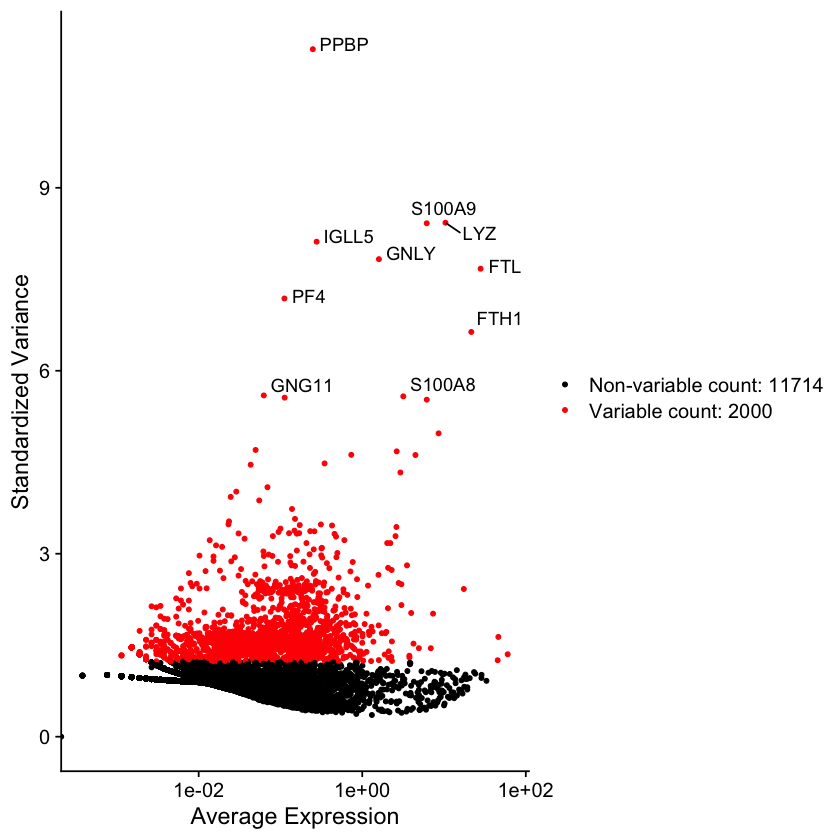

In [12]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2

After this, we need to scale the data. This is to ensure that all genes are along the same scale and simplifies downstream processes like Dimensionality Reduction.

In [13]:
pbmc <- ScaleData(pbmc)

Centering and scaling data matrix



### STEP 3: PCA, Dimensionality Reduction and clustering

Having transformed the data and identified the top variable features, we can now perform PCA and Dimensionality Reduction.
PCA is a common tool to reduce the dimension of the dataset and capture variability into principal components. [This video by the StatQuest channel explains this concept very well.](https://www.youtube.com/watch?v=FgakZw6K1QQ&ab_channel=StatQuestwithJoshStarmer)


We run pca using the `RunPCA()` function from the Seurat package, and use `features` option to specify the variable features. This generally speeds up the analysis because you have already identified the most variable features, telling the PCA method which genes to look at. Although equally, you could run this on the full geneset (but it will take longer and will likely be a bit more noisy

In [20]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

We can also look at the top genes for each principal component.

In [22]:
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


We can also visualize the loadings for each PC. Here we look at PC1-4.

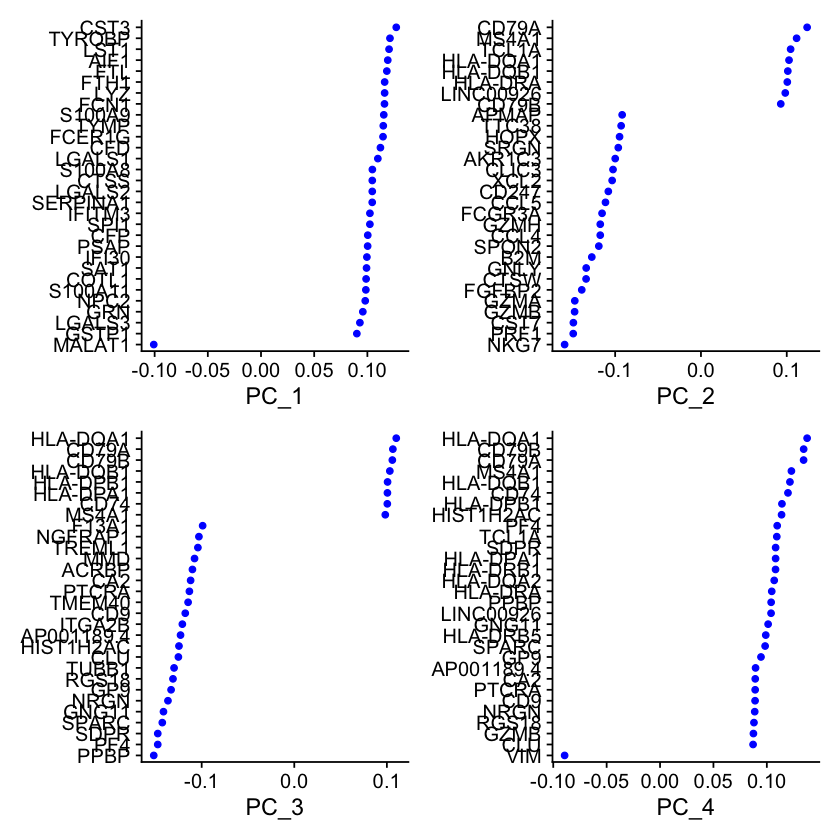

In [25]:
VizDimLoadings(pbmc, dims = 1:4, reduction = "pca")

We can also visualize these in heatmaps using the `DimHeatmap()` function, which will clearly show the genes that drive the differences between cells.

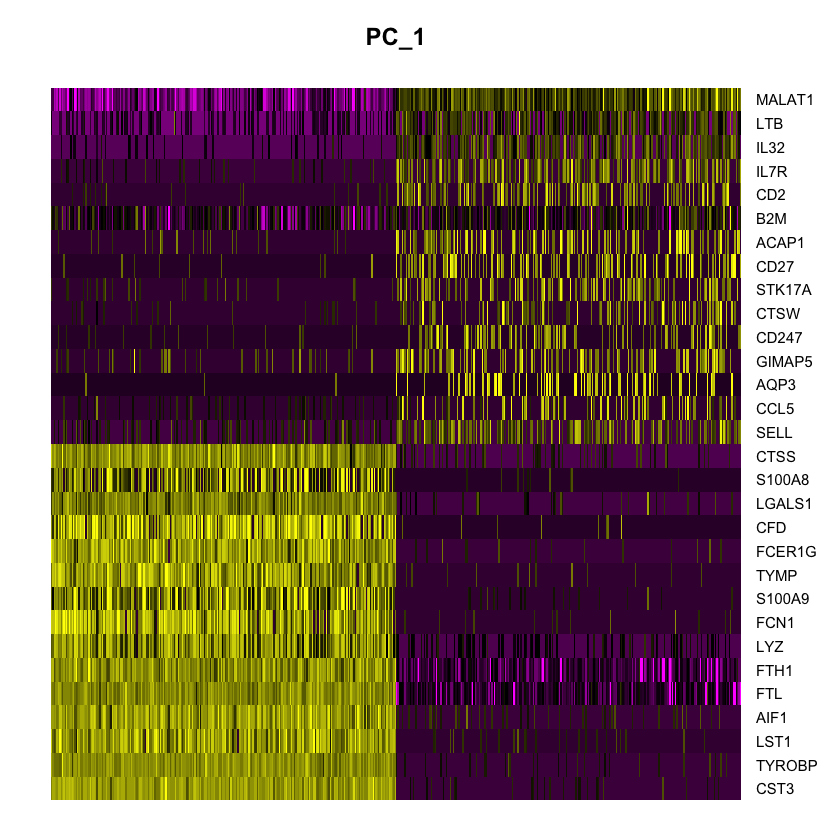

In [28]:
DimHeatmap(pbmc, dims = 1,cells=500,balanced=TRUE)

> Tip: Try looking at other PCs by changing the "`dims=1`" parameter! You can change it to a specific PC (i.e `dims=2`) or using a specific set (`dims=c(1,5,10))`, `dims=4:8`

What we learn from this is that there is a lot of variation in single-cell data, much of which might be noise. PCA allows you to compress the noise into specific principal components. and `Seurat` uses these to guide the clustering of all the cells. This is an important step in separating specific cell-types from your full dataset.

First, we want to identify the number of PCs to use, i.e how many are informative. PC1 will capture the most information, followed by PC2 etc.... But how many PCs do we need? Not all of this information is useful and might unnecessarily strain the computation.

To choose the number of PCs, we can use something called a "JackStraw" procedure, which randomly permutes a subset of the data on which PCA is rerun. This constructs a "null" distribution of feature/gene scores and is repeated multiple times to get an associated p-value. In turn, this allows us to add a significance to the PCs and therefore a choice in which ones to take forward.

`Seurat` conveniently has the `JackStraw()`,`ScoreJackStraw()` and `JackStrawPlot()` functions to visualize this.

An alternative method is to generate something called an "Elbow plot" using the `ElbowPlot()` function, which ranks the principal components based on the variance explained by each one.


In [29]:
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

Warning message:
“Removed 23516 rows containing missing values (`geom_point()`).”


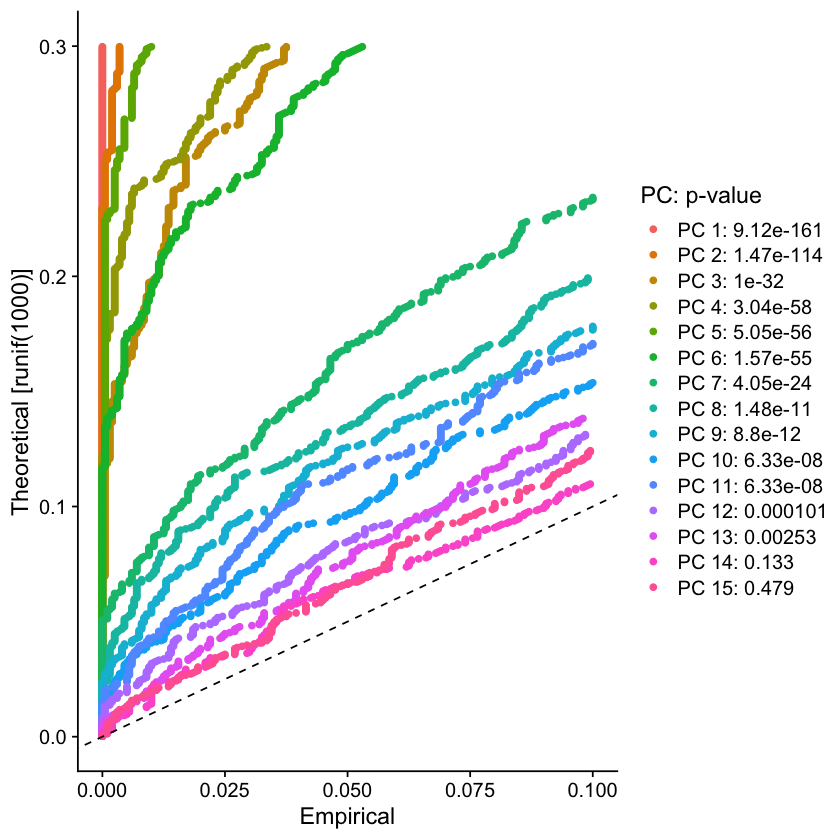

In [30]:
JackStrawPlot(pbmc, dims = 1:15)

Here, we can safely say that PC1-11 are significant and will be useful in the downstream analysis. The elbow plot below says more or less the same thing, observing an elbow around PC9-10. This tells us that the majority of true signal is capture in the first 10 PCs.

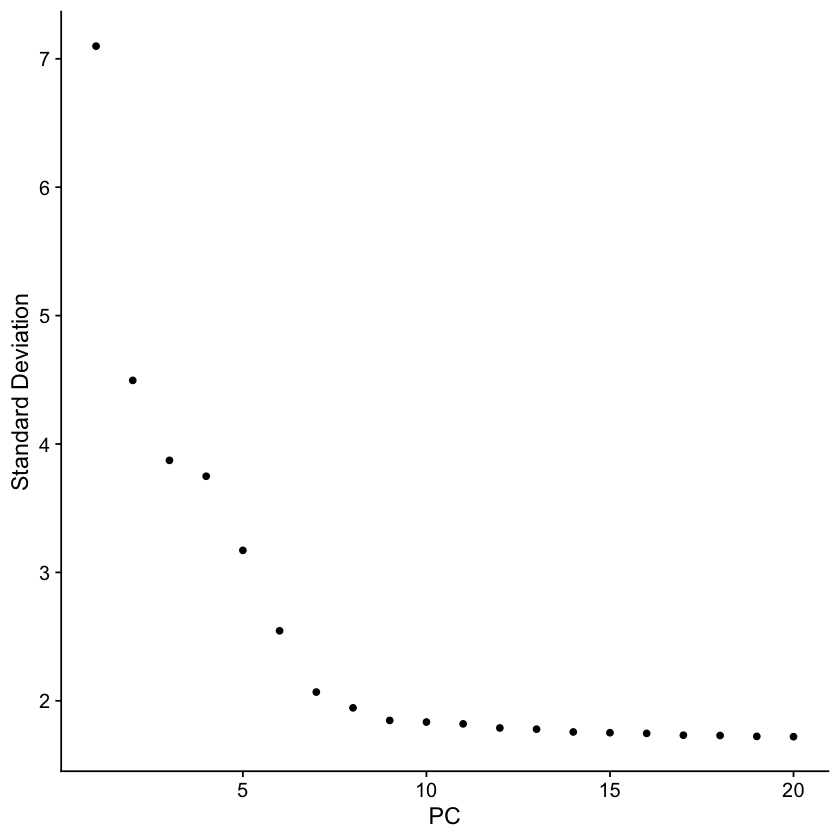

In [31]:
ElbowPlot(pbmc)

Identifying the true dimensionality of a dataset – can be challenging/uncertain for the user. In this example, all three approaches yielded similar results, but we might have been justified in choosing anything between PC 7-12 as a cutoff.

We chose 10 here, but encourage you to consider the following:

- Dendritic cell and NK aficionados may recognize that genes strongly associated with PCs 12 and 13 define rare immune subsets (i.e. MZB1 is a marker for plasmacytoid DCs). However, these groups are so rare, they are difficult to distinguish from background noise for a dataset of this size without prior knowledge.
- In practice, you should repeat downstream analyses with a different number of PCs (10, 15, or even 50!). As you will observe, the results often do not differ dramatically.
- Generally, err on the higher side when choosing the number of PCs. For example, performing downstream analyses with only 5 PCs does significantly and adversely affect results; using 20 PCs instead of 15 might not. But this highly depends on the dimension of your dataset, as larger datasets might have much more variance.

### STEP 4: Clustering and annotation

Using this information, we can finally cluster the cells. Seurat applies a graph-based clustering approach. This consists of basically calculating the mathematical distance between cells (using the expression of their genes and the PCA information) to first find "neighbours" (i.e, cells which are similar to eachother). This is followed by "clustering", which is basically to assign all the cells which are close to eachother (i.e "neighbourhoods") to a certain cluster number.

We do this using two functions from the `Seurat` package; `FindNeighbors()` and `FindClusters()`.

Note that the `FindNeighbors()` function has been specified with the parameter `dims=1:10`, which tells the function to use PCs 1-10 as previously decided.


In [61]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


To see that they have been ID'd, we can look at the identity of the first 5 cells.

In [62]:
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               2                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

Finally, we run a type of non-linear dimensional reduction. The goal of these methods are to find the underlying structure in the data to place similar cells together into a low-dimensional space (i.e, something that can be visualized and understood by the user). There are two methods that can be used here, tSNE and UMAP. They differ slightly in their approach but the goal is the same.

> Note, UMAP and tSNE are learning algorithms, and so the results will differ slightly in their representation everytime you run the algorithm. You can try this out yourself. If you want to get the exact same UMAP/tSNE plot every time, you can use the R function `set.seed()` and set a specific number to ensure that the model follows the same randomization.

In [63]:
## optional
set.seed(123)

In [64]:
pbmc <- RunUMAP(pbmc, dims = 1:10)

09:39:46 UMAP embedding parameters a = 0.9922 b = 1.112

09:39:46 Read 2638 rows and found 10 numeric columns

09:39:46 Using Annoy for neighbor search, n_neighbors = 30

09:39:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:39:46 Writing NN index file to temp file /var/folders/d1/c0gtk7ks6ys530cnjd7_s11c0000gn/T//RtmpQcs13C/file490745fad4b0

09:39:46 Searching Annoy index using 1 thread, search_k = 3000

09:39:47 Annoy recall = 100%

09:39:47 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

09:39:47 Initializing from normalized Laplacian + noise (using irlba)

09:39:48 Commencing optimization for 500 epochs, with 105124 positive edges

09:39:52 Optimization finished



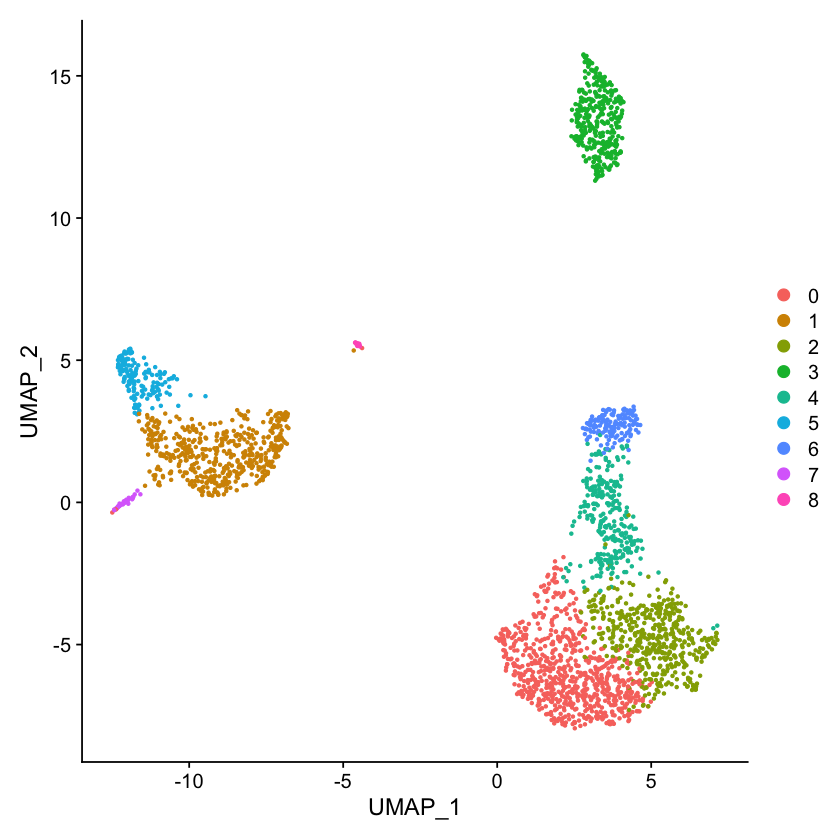

In [65]:
DimPlot(pbmc, reduction = "umap")

And we can test this for tSNE as well.

In [66]:
pbmc<-RunTSNE(pbmc,dims=1:10)

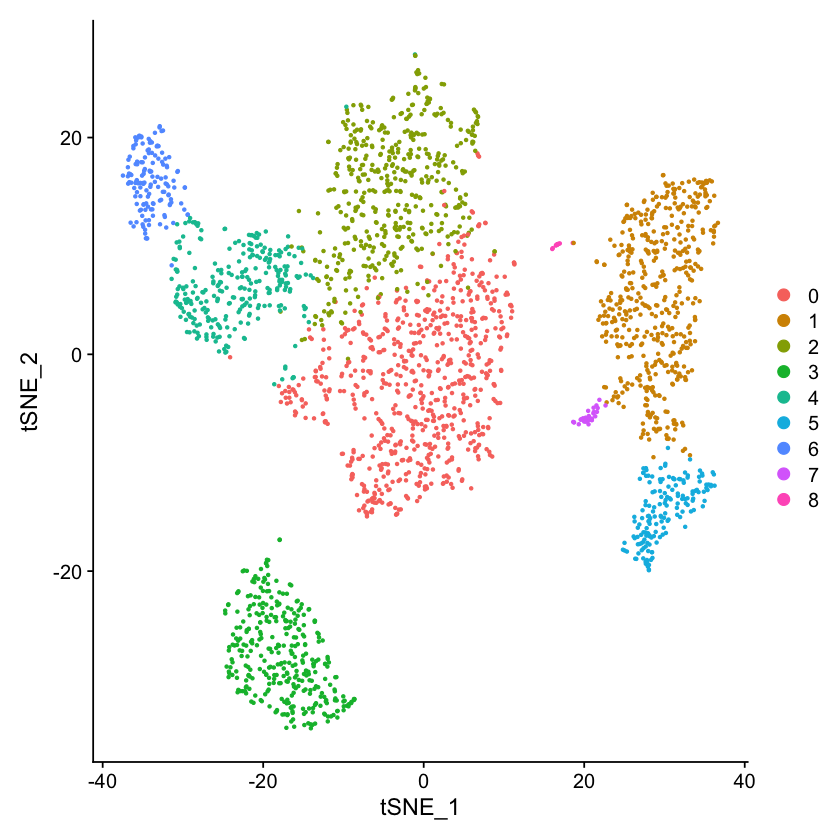

In [67]:
DimPlot(pbmc, reduction = "tsne")

We see here that the UMAP representation seems to cluster the data better.

> Tip: Try re-running the FindClusters at the top but with different resolutions, such as `FindClusters(pbmc, resolution = 0.1)` and see how the number of clusters differ.

Now that we have been able to cluster the cells, let's identify which cell-type each cluster represesents! To do this, Seurat conveniently has a function called `FindAllMarkers()`, which will essentially test differential expression between each cluster. This will give you a list of the most differentially expressed genes for each cluster relative to all other clusters (negative or positively differentially expressed).

We can also visualize the genes and their associated p-value for the differential expression testing.

> Note, this will count on the number of clusters you currently have. So if you did test out the `resolution` parameter for `FindClusters()`, set this back to 0.5.

In [68]:
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.167632e-83,1.333503,0.435,0.108,1.601290e-79,0,CCR7
1.740957e-109,1.069166,0.897,0.593,2.387549e-105,0,LDHB
0.000000e+00,5.570063,0.996,0.215,0.000000e+00,1,S100A9
0.000000e+00,5.477394,0.975,0.121,0.000000e+00,1,S100A8
7.994465e-87,1.282860,0.981,0.644,1.096361e-82,2,LTB
2.610017e-59,1.240361,0.424,0.111,3.579377e-55,2,AQP3
0.000000e+00,4.310172,0.936,0.041,0.000000e+00,3,CD79A
9.481783e-271,3.591579,0.622,0.022,1.300332e-266,3,TCL1A
4.932509e-169,3.006739,0.595,0.056,6.764443e-165,4,GZMK


We can extract the features and plot them directly onto the clusters, or visualize specific genes using violin plots.

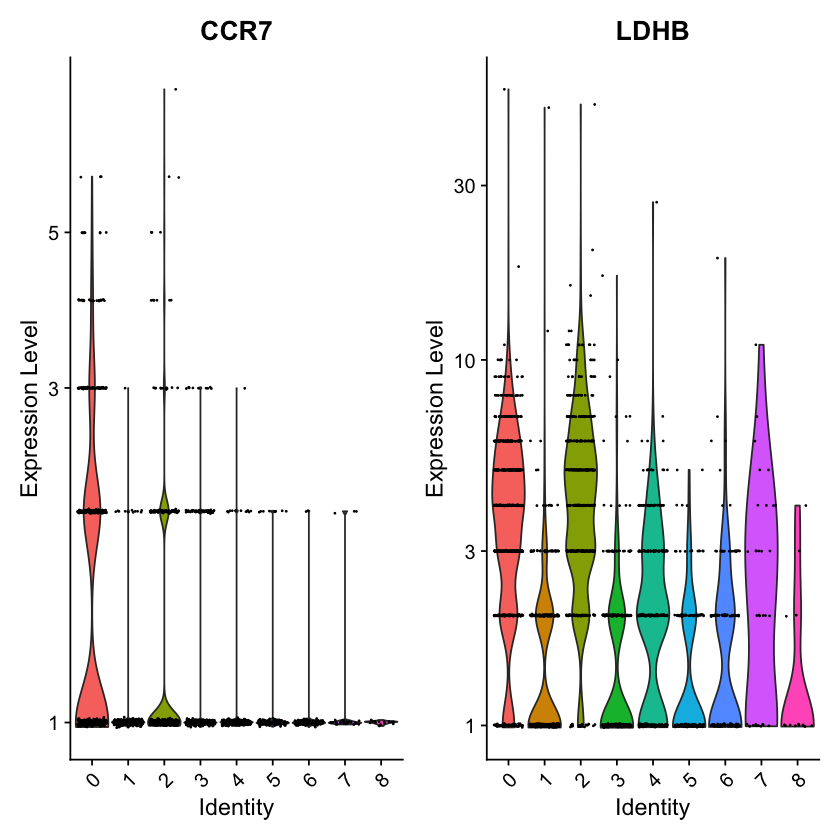

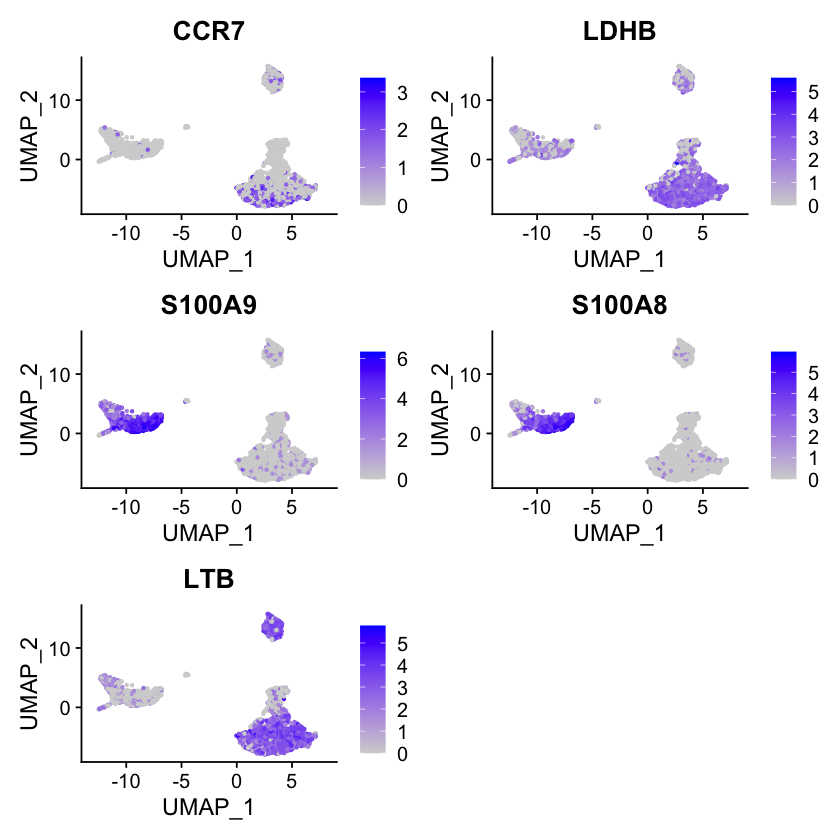

In [77]:
##extract vector of markers

markers=pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)
markers=markers$gene

VlnPlot(pbmc, features = markers[1:2], slot = "counts", log = TRUE)
FeaturePlot(pbmc, features = markers[1:5])

Or, if you have specific marker genes in mind (such as a known list of cell-type markers);

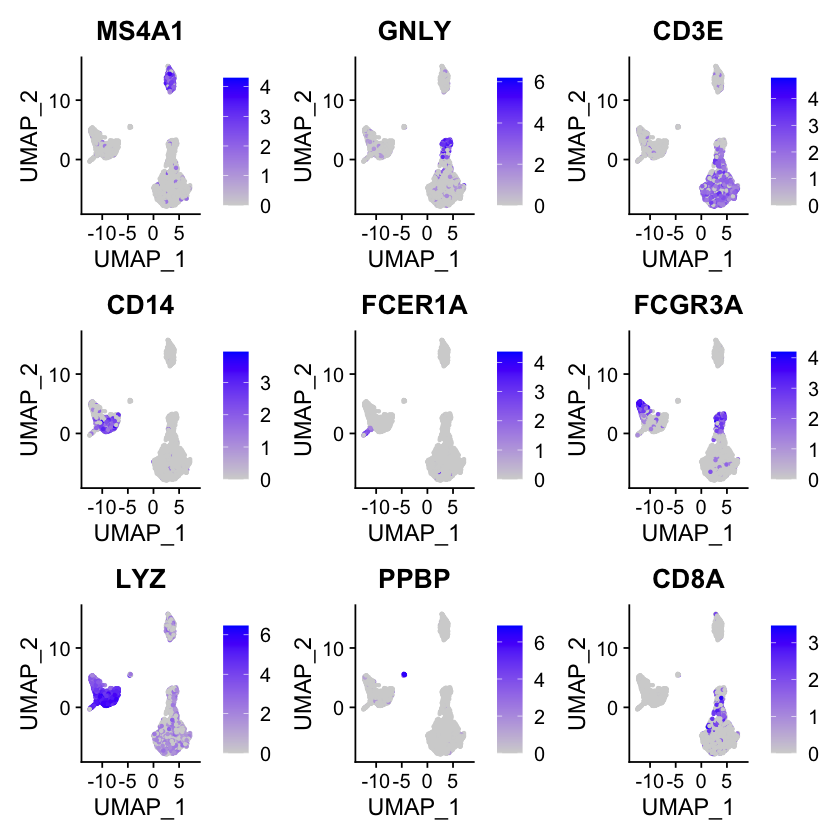

In [78]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",
    "CD8A"))

Seurat conveniently has a `DoHeatmap()` function which we used earlier for the PCs. We can use this again for the clusters and the marker genes.

Warning message in DoHeatmap(pbmc, features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: CD8A, VPREB3, PIK3IP1, PRKCQ-AS1, NOSIP, LEF1, CD3E, CD3D, CCR7, LDHB, RPS3A”


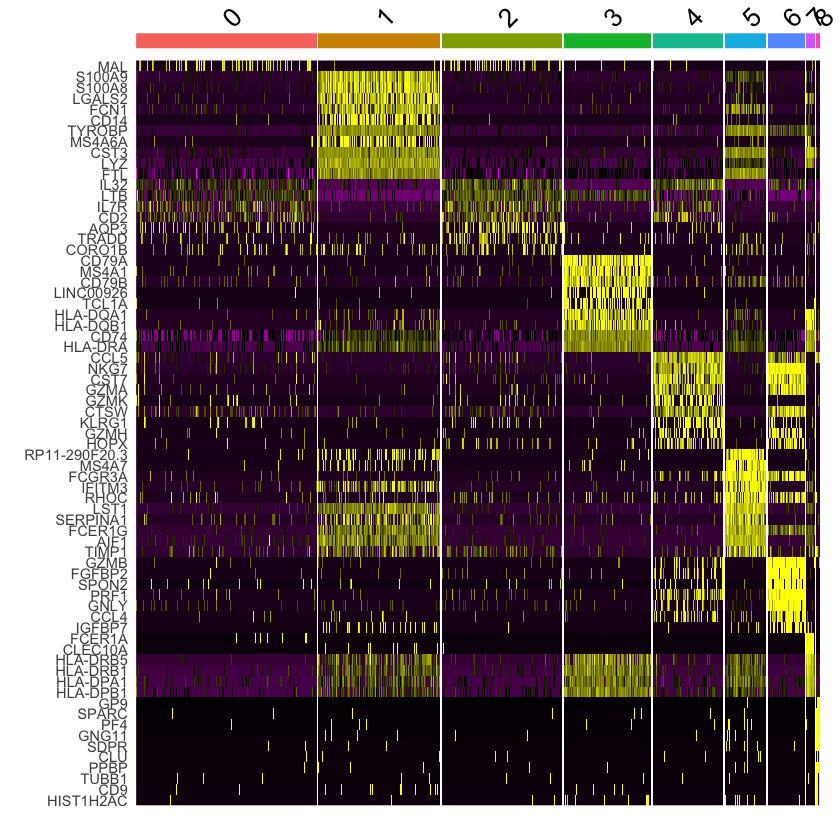

In [79]:
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

Now that we've managed to visualize how these clusters differ, lets annotate! In this case, we will use a known list of marker genes for this immune cell-type. We can look at them one by one. By plotting the marker gene next to the cluster UMAP.


| Genes       | Cell-type |
| ----------- | ----------- |
| IL7R, CCR7      | Naive CD4+ T      |
| CD14, LYZ   | CD14+ Mono       |
| IL7R, S100A4   | Memory CD4+       |
| MS4A1   | B       |
| CD8A   | CD8+ T       |
| FCGR3A, MS4A7   | FCGR3A+ Mono       |
| GNLY, NKG7  | NK      |
| FCER1A, CST3  | DC     |
| PPBP  | Platelet    |


Lets see if we can find the B-cell cluster;



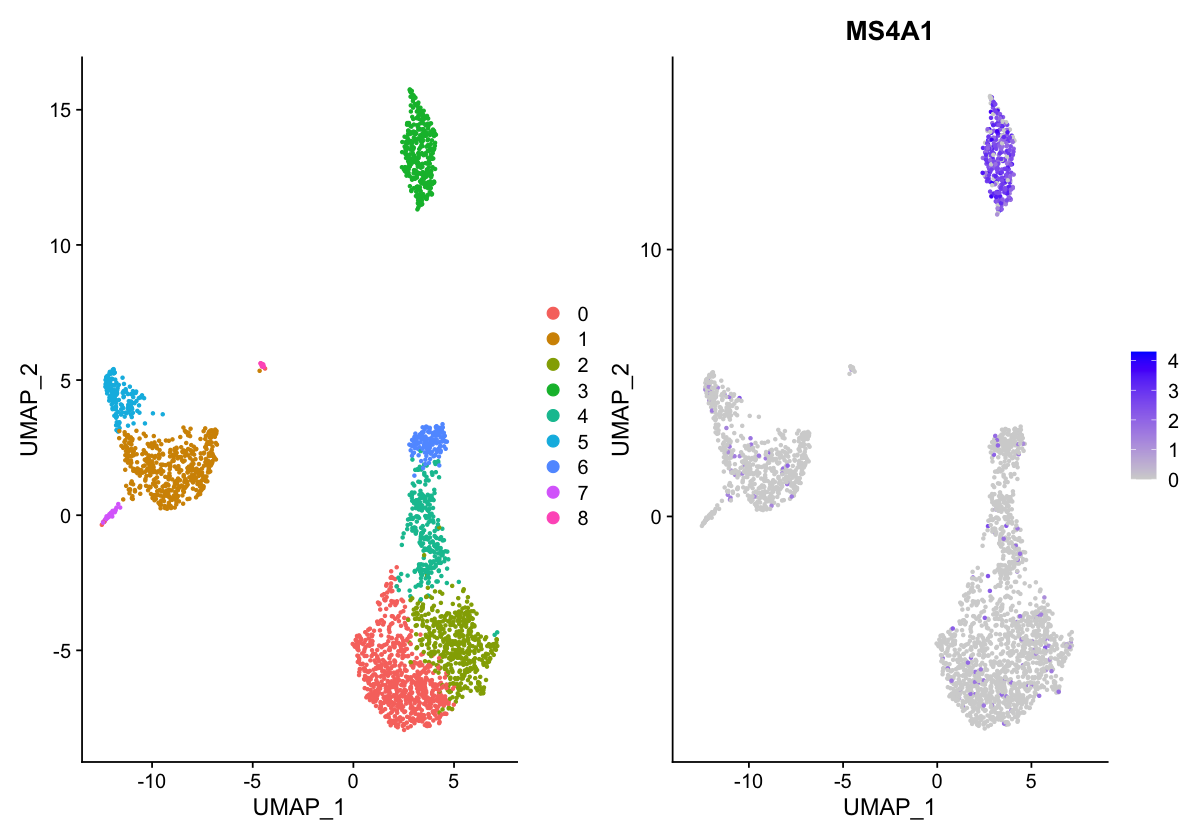

In [85]:
p1=DimPlot(pbmc, reduction = "umap")
p2=FeaturePlot(pbmc,features="MS4A1")
p1+p2

Here, we can quite clearly see that cluster 3 seems to be the B-cells.

We could also simply do a heatmap for all of them. We suggest using both methods as its not always so clear!

In [93]:
markergenes=c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP","CD8A")

To rename the clusters, we can name them directly by using the R `levels()` function. This gives you all the unique clusters of the single-cell object. Next, we rename it according to the cell-types we've identified. Note that these need to be in the same order as the levels (or make sure you name the right "level" the right cell-type cluster!)

Warning message in DoHeatmap(pbmc, features = markergenes):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: CD8A, CD3E”


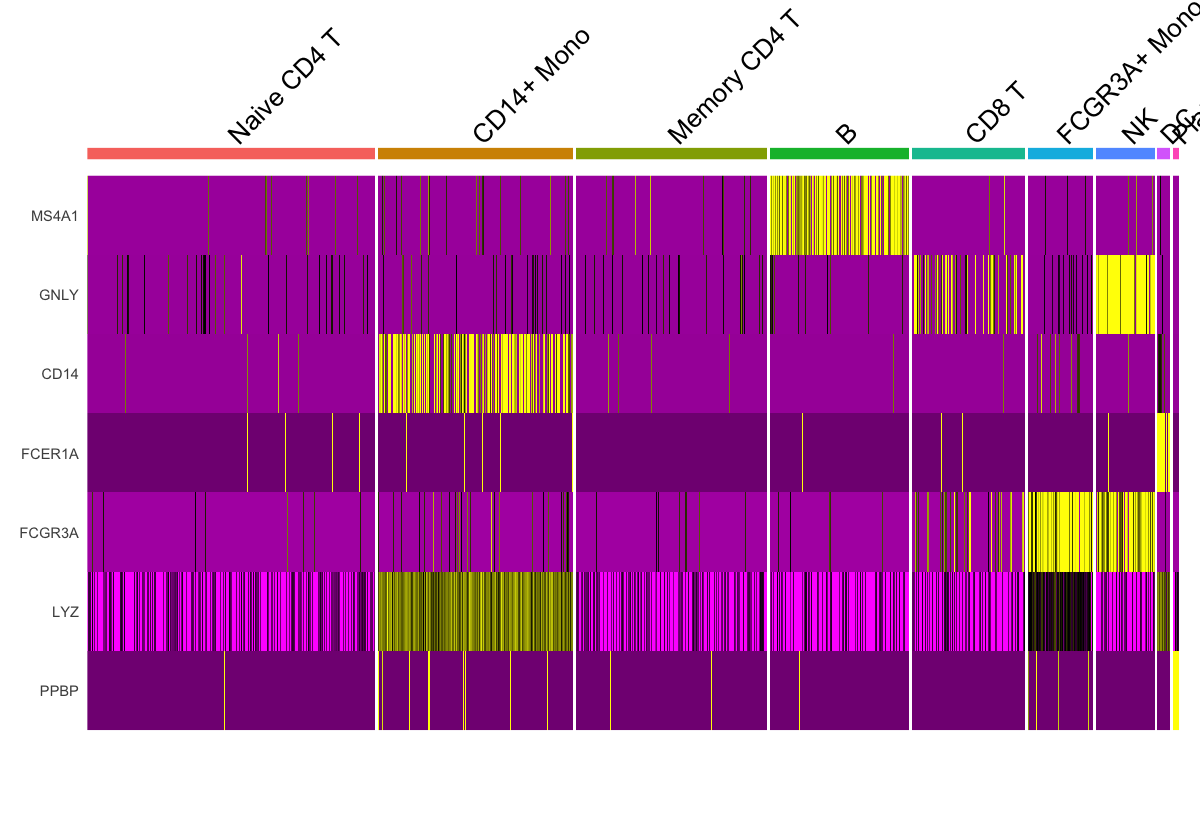

In [94]:
DoHeatmap(pbmc, features = markergenes)+NoLegend()

In [90]:
levels(pbmc)
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids)=levels(pbmc)

[1] "0" "1" "2" "3" "4" "5" "6" "7" "8"

In [91]:
pbmc <- RenameIdents(pbmc, new.cluster.ids)

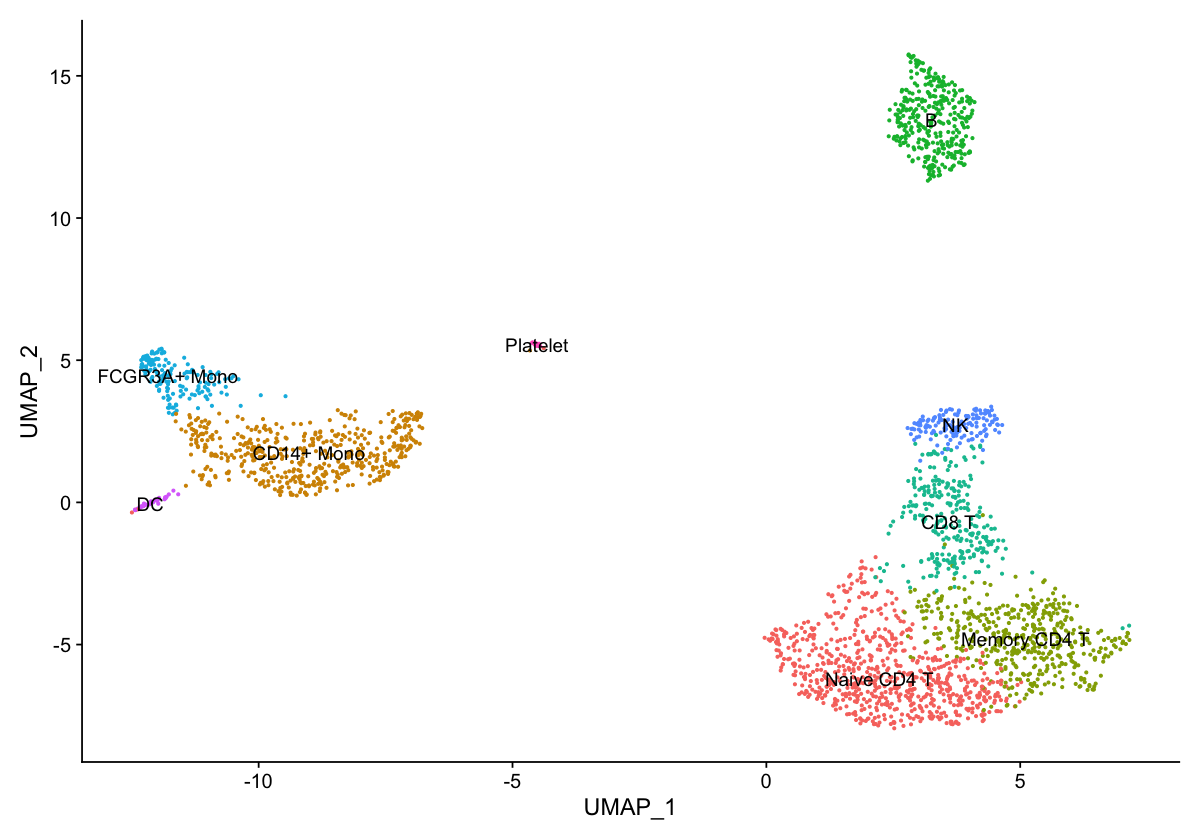

In [92]:
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()